# Signature Verification
# 0.0 Problem Statement
This problem involves verification of signatures as genuine or fraud.
To solve this problem we use deep learning CNN algorithm.  

# 1.0 Import  Data & Explore Characteristic

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/sig

/content/drive/MyDrive/sig


The data is sourced from kaggle.       
https://www.kaggle.com/datasets/robinreni/signature-verification-dataset/code?datasetId=107946&sortBy=voteCount

In [ ]:
!unzip sinature-ver-data.zip

Archive:  sinature-ver-data.zip
  inflating: sign_data/sign_data/test/049/01_049.png  
  inflating: sign_data/sign_data/test/049/02_049.png  
  inflating: sign_data/sign_data/test/049/03_049.png  
  inflating: sign_data/sign_data/test/049/04_049.png  
  inflating: sign_data/sign_data/test/049/05_049.png  
  inflating: sign_data/sign_data/test/049/06_049.png  
  inflating: sign_data/sign_data/test/049/07_049.png  
  inflating: sign_data/sign_data/test/049/08_049.png  
  inflating: sign_data/sign_data/test/049/09_049.png  
  inflating: sign_data/sign_data/test/049/10_049.png  
  inflating: sign_data/sign_data/test/049/11_049.png  
  inflating: sign_data/sign_data/test/049/12_049.png  
  inflating: sign_data/sign_data/test/049_forg/01_0114049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0206049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0210049.PNG  
  inflating: sign_data/sign_data/test/049_forg/02_0114049.PNG  
  inflating: sign_data/sign_data/test/049_forg/02_02

In [ ]:
# Import common libraries
import os
import shutil
import glob
import cv2
import random
import math
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Import tensorflow and its modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.utils.set_random_seed(111) # set random seed
# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')
# import callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,TensorBoard
import datetime

%load_ext tensorboard
!rm -rf ./logs/

## 2.0 Exploratory Data Analysis   
### 2.1 Image Plots

In [ ]:
train_path="/content/drive/MyDrive/sig/sign_data/train"
test_path="/content/drive/MyDrive/sig/sign_data/test/"

Sample Genuine Signature
 image dimensions ht,wdt,chan: (359, 725, 3)


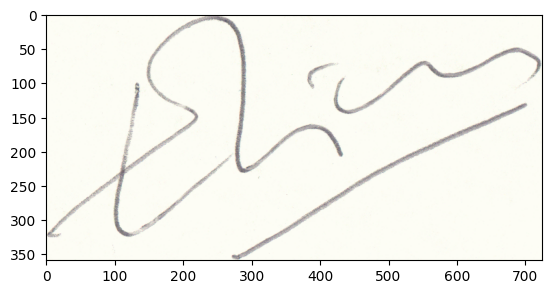

In [ ]:
imag_path = '/content/drive/MyDrive/sig/sign_data/train/001/001_01.PNG'
image = cv2.imread(imag_path)
height, width, channels = image.shape
print('Sample Genuine Signature')
print (f' image dimensions ht,wdt,chan: {height, width, channels}')
plt.imshow(image)
plt.show()

Sample Forged Signature
 image dimensions ht,wdt,chan: (312, 629, 3)


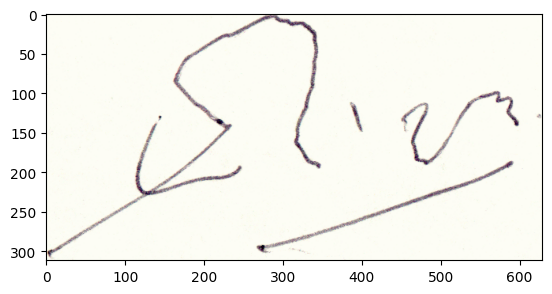

In [ ]:
imag_path ='/content/drive/MyDrive/sig/sign_data/train/001_forg/0119001_01.png'
image = cv2.imread(imag_path)
height, width, channels = image.shape
print('Sample Forged Signature')
print (f' image dimensions ht,wdt,chan: {height, width, channels}')
plt.imshow(image)
plt.show()

### 2.2 Dataset Characteristic
The dataset provided contains train and test folders.      
In train folder there are  two types      
1) genuine signature folder        
2) fradulent signature folder (format  "\***_forg***" )   

In [ ]:
def load_images_from_folder(fpath):
  '''
  Load image data
  '''
  img_data = []
  img_labels = []
  img_w=224
  img_h=224
  #
  for folder in os.listdir(fpath):
    subfold = os.path.join(fpath, folder)
    for filename in os.listdir(subfold):
      try:
        ipath = os.path.join(subfold, filename)
        img = cv2.imread(ipath)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(img_h,img_w))
        img_data.append([img])
        if folder.endswith('g'):
          img_labels.append(1)
        else:
          img_labels.append(0)
      except:
         print('error:',subfold)

  img_data = np.array(img_data)/255.0
  img_data = img_data.reshape(-1, img_h,img_w, 3)
  img_labels = np.array(img_labels)
  return img_data,img_labels


In [ ]:
train_data ,train_labels =  load_images_from_folder(train_path)

In [ ]:
train_data.shape

(1649, 224, 224, 3)

In [ ]:
from keras.utils import to_categorical
train_labels_cat = to_categorical(train_labels)

In [ ]:
test_labels_cat = to_categorical(test_labels)

In [ ]:
test_data ,test_labels =  load_images_from_folder(test_path)

In [ ]:
test_data.shape

(500, 224, 224, 3)

## 2.1 Class Distribution¶   
Counts of genuine,fake signatures

In [ ]:
pd.DataFrame(train_labels).value_counts()

0    887
1    762
dtype: int64

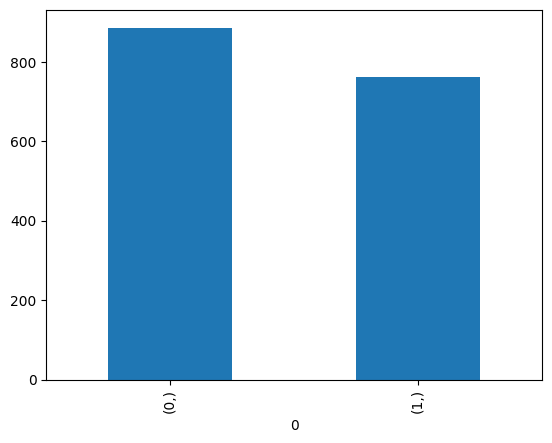

In [ ]:
pd.DataFrame(train_labels).value_counts().plot(kind='bar')
plt.show()

# 3.0 Pre-Trained Models (VGG16)
## 3.1 Transfer Learning

In [ ]:
#create model using vgg16

height=224
width=224

base_model = keras.applications.VGG16(
weights='imagenet', # Load weights pre-trained on ImageNet.
input_shape=(224, 224, 3),
include_top=False) # Do not include the ImageNet classifier at the top.
base_model.trainable = False
#
x = layers.GlobalMaxPooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(2, activation='softmax')(x)
model_vgg = keras.Model(base_model.input, output)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg.compile(optimizer=keras.optimizers.Adam(1e-4),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
## create callbacks
call_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=6,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.00001)

call_es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5)

logdir = "logs/model_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
call_tb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
call_mb =  keras.callbacks.ModelCheckpoint(filepath, verbose=1,
  monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
hist_vgg = model_vgg.fit(train_data,train_labels_cat,
                         epochs=50,batch_size=64,validation_split=.2,
                         callbacks=[call_lr, call_es, call_mb]
                         )

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.5542
Epoch 1: val_accuracy improved from -inf to 0.71818, saving model to weights-improvement-01-0.72.hdf5
21/21 [==============================] - 33s 861ms/step - loss: 0.7390 - accuracy: 0.5542 - val_loss: 0.6234 - val_accuracy: 0.7182 - lr: 1.0000e-04
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.6224
Epoch 2: val_accuracy improved from 0.71818 to 0.77879, saving model to weights-improvement-02-0.78.hdf5
21/21 [==============================] - 7s 319ms/step - loss: 0.6433 - accuracy: 0.6224 - val_loss: 0.5593 - val_accuracy: 0.7788 - lr: 1.0000e-04
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.5909 - accuracy: 0.6937
Epoch 3: val_accuracy improved from 0.77879 to 0.79091, saving model to weights-improvement-03-0.79.hdf5
21/21 [==============================] - 7s 323ms/step - loss: 0.5909 - accuracy: 0.6937 - val_loss: 0.5100 -

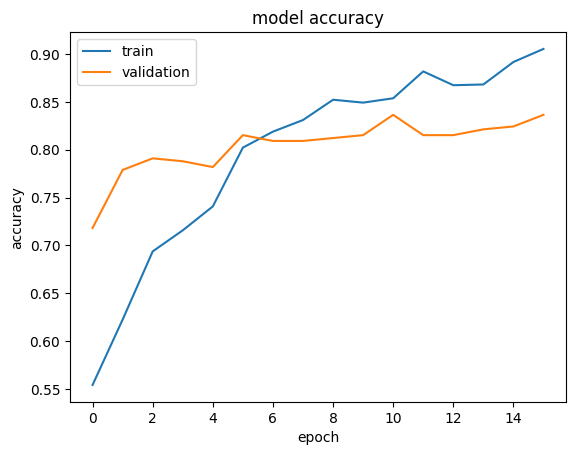

In [ ]:
#  "Accuracy"
plt.plot(hist_vgg.history['accuracy'])
plt.plot(hist_vgg.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

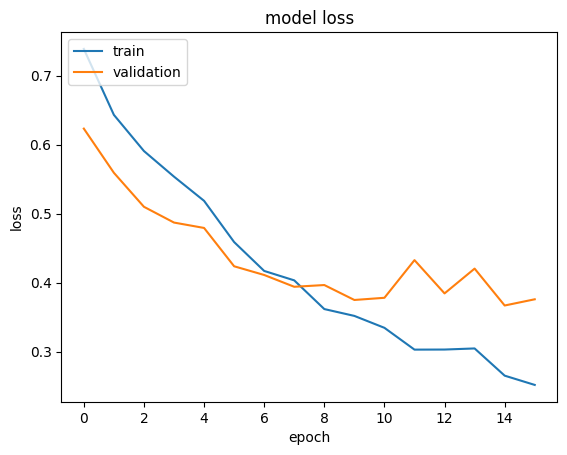

In [ ]:
# "Loss"
plt.plot(hist_vgg.history['loss'])
plt.plot(hist_vgg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 4.0 Pre-Trained Models (RESNET50)
## 4.1 Transfer Learning

In [ ]:
#create model using ResNet50

height=224
width=224

base_model = keras.applications.ResNet50(
weights='imagenet', # Load weights pre-trained on ImageNet.
input_shape=(224, 224, 3),
include_top=False) # Do not include the ImageNet classifier at the top.
base_model.trainable = False
#
x = layers.GlobalMaxPooling2D()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(2, activation='softmax')(x)
model_res = keras.Model(base_model.input, output)

In [ ]:
model_res.compile(optimizer=keras.optimizers.Adam(1e-4),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [ ]:
## create callbacks
call_lr = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.7,
                                            min_lr=0.00001)

call_es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10)

logdir = "logs/model_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
call_tb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
call_mb =  keras.callbacks.ModelCheckpoint(filepath, verbose=1,
  monitor='val_accuracy', mode='max', save_best_only=True)

In [ ]:
hist_res = model_res.fit(train_data,train_labels_cat,
                         epochs=50,batch_size=64,validation_split=.2,
                         callbacks=[call_lr, call_es, call_mb]
                         )

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.0258 - accuracy: 0.5497
Epoch 1: val_accuracy improved from -inf to 0.83636, saving model to weights-improvement-01-0.84.hdf5
21/21 [==============================] - 12s 371ms/step - loss: 1.0258 - accuracy: 0.5497 - val_loss: 0.4521 - val_accuracy: 0.8364 - lr: 1.0000e-04
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.6313 - accuracy: 0.6778
Epoch 2: val_accuracy did not improve from 0.83636
21/21 [==============================] - 5s 262ms/step - loss: 0.6313 - accuracy: 0.6778 - val_loss: 0.5112 - val_accuracy: 0.7364 - lr: 1.0000e-04
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.5355 - accuracy: 0.7354
Epoch 3: val_accuracy did not improve from 0.83636
21/21 [==============================] - 5s 255ms/step - loss: 0.5355 - accuracy: 0.7354 - val_loss: 0.4512 - val_accuracy: 0.7758 - lr: 1.0000e-04
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0

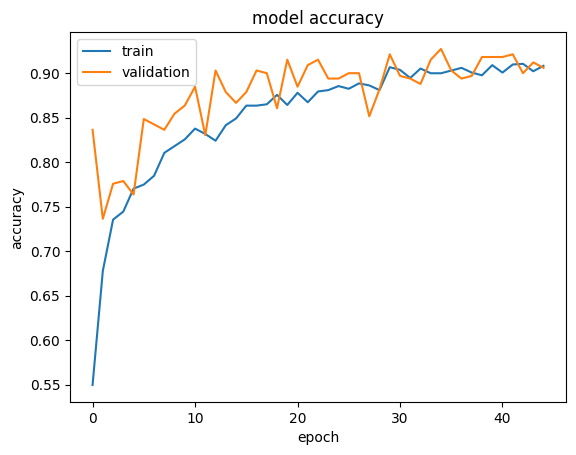

In [ ]:
#  "Accuracy"
plt.plot(hist_res.history['accuracy'])
plt.plot(hist_res.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

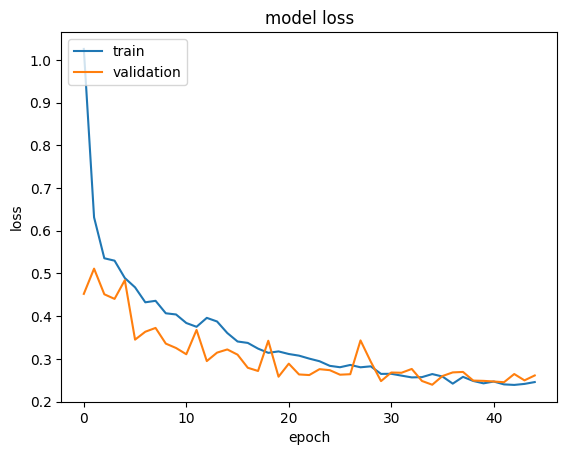

In [ ]:
# "Loss"
plt.plot(hist_res.history['loss'])
plt.plot(hist_res.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# 5.0 Summary   

The validation accuracy of the models are:
-    Vgg16: 83.6   
- ResNet50: 92.7   